In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def cria_instancia(nome_arquivo):
    with open(nome_arquivo, 'r') as f:
        vrp = f.readlines()  #Lendo a instância
    
    #Descobindo índices para fatiamento futuro
    index_nos = vrp.index('NODE_COORD_SECTION \n')  
    index_demanda = vrp.index('DEMAND_SECTION \n')
    
    #número de ônibus
    qtd_onibus = int(vrp[1].split(':')[2][1])
    
    #capacidade
    capacidade = int(vrp[5].split(':')[1].strip())
    
    #Coordenada das "lojas"
    coord_variaveis = list(map(lambda x: np.array(x.strip().split(' ')[1:3], dtype = np.float32) , vrp[index_nos+1:index_demanda]))

    qtd_variaveis = len(vrp[index_nos+1:index_demanda]) -1 #desconsidera o depósito como variável
    
    #Cria dicionário com as distâncias euclidianas entre os nós
    dict_distancias = {f'c{i},{j}': np.round(np.linalg.norm(coord_variaveis[i]-coord_variaveis[j]),2) for i in range(qtd_variaveis+1) for j in range(qtd_variaveis+1)}
    
    #Armazena as demandas de cada cliente
    vetor_demandas = list(map(lambda lista: float(lista.split(' ')[1]),vrp[index_demanda+2:index_demanda+2+qtd_variaveis]))
    
    #Cria rótulos para as variaveis
    origens = [i for i in range(qtd_variaveis+1)] #0 corresponde ao depósito
    destinos = [i for i in range(qtd_variaveis+1)]
    onibus = [j+1 for j in range(qtd_onibus)]
    
    #Dicionário com as demandas
    dict_demandas = {i+1: vetor_demandas[i] for i in range(qtd_variaveis)}

    return capacidade,dict_distancias, dict_demandas, origens, destinos, onibus, coord_variaveis

In [3]:
capacidade,dict_distancias, demandas, origens, destinos, onibus, coord = cria_instancia(nome_arquivo = 'Lista2.txt')

In [4]:
coord_x = np.array([x for x,_ in coord[1:] ]) - coord[0][0]
coord_y = np.array([y for _,y in coord[1:]]) - coord[0][1]

In [5]:
angulos = np.zeros((2,coord_x.shape[0]))

In [6]:
angulos[0] = np.arange(1,11,1)

In [7]:
inicio_arbitrario = 2*np.pi*np.random.random()

In [8]:
angulos[1] = np.arctan2(coord_y,coord_x) + inicio_arbitrario

In [9]:
angulos

array([[ 1.        ,  2.        ,  3.        ,  4.        ,  5.        ,
         6.        ,  7.        ,  8.        ,  9.        , 10.        ],
       [ 1.36114061,  0.52529073,  0.49691629,  0.16333199,  5.42058468,
         0.46784282,  1.00273168,  0.03078055, -0.1888659 ,  5.58531523]])

In [10]:
angulos = angulos.T

In [11]:
df = pd.DataFrame(angulos, columns = ['Loja','Angulo'])

In [12]:
def zero_2pi(x):
    if x<0:
        return x + 2*np.pi
    elif x > 2*np.pi:
        return x - 2*np.pi
    else: 
        return x

In [13]:
df['Angulo'] = df['Angulo'].map(zero_2pi)

In [14]:
df = df.sort_values(by='Angulo', ascending=True)

In [15]:
df

,Loja,Angulo
7,8.0,0.030781
3,4.0,0.163332
5,6.0,0.467843
2,3.0,0.496916
1,2.0,0.525291
6,7.0,1.002732
0,1.0,1.361141
4,5.0,5.420585
9,10.0,5.585315
8,9.0,6.094319


In [16]:
capacidades = [50,50,50]

In [17]:
rotas = []
rota = [0]
i=0
capacidade_disponivel = capacidades[i]
for j in df['Loja']:
    if demandas[j] <= capacidade_disponivel:
        rota.append(j)
        capacidade_disponivel -= demandas[j]
    else: 
        rota.append(0)
        rotas.append(rota)
        rota = [0, j]
        i+=1
        capacidade_disponivel = capacidades[i] - demandas[j]
rota.append(0)
rotas.append(rota)

In [18]:
rotas

[[0, 8.0, 4.0, 6.0, 3.0, 0], [0, 2.0, 7.0, 0], [0, 1.0, 5.0, 10.0, 9.0, 0]]

In [19]:
G = nx.Graph()

for i in range(len(coord)):
    G.add_node(i, pos = (coord[i][0],coord[i][1]))

In [20]:
cores = ['r','b','g','k']
num = -1
rotulos = dict()
i = 1
c = 0
for rota in rotas:
    for u,v in zip(rota[:-1], rota[1:]):
        G.add_edge(u,v, color=cores[c], weight=2)
    rotulos[(u,v)] = f'Onibus_{i}'
    i+=1
    c+=1

In [21]:
pos=nx.get_node_attributes(G,'pos')

arestas = G.edges()

cores = [G[u][v]['color'] for u,v in arestas]
pesos = [G[u][v]['weight'] for u,v in arestas]

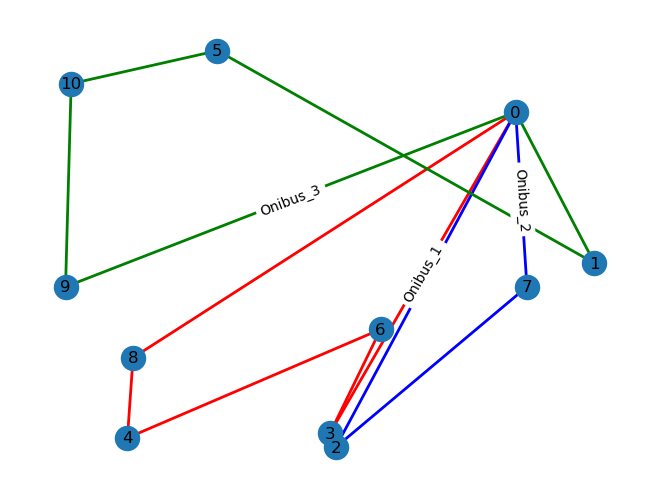

In [22]:
nx.draw(G, pos, with_labels=True, edge_color = cores, width = pesos)
nx.draw_networkx_edge_labels(G, pos, edge_labels = rotulos)
plt.savefig('Grafo2_lista_2')
plt.show()

In [74]:
2*np.pi-inicio_arbitrario

3.763658773629497

In [29]:
def calcula_custo(rotas):
    custo = 0
    for rota in rotas:
        for u,v in zip(rota[:-1], rota[1:]):
            custo+= dict_distancias[f'c{int(u)},{int(v)}']
    return custo

In [30]:
custo = calcula_custo(rotas)
custo

689.2499980926514

In [68]:
#2-opt
rotas2 = []
for rota in rotas:
    custo = calcula_custo([rota])
    rotas2.append(rota)
    for u in rota[1:-1]:
        for v in rota[1:-1]:
            rota2 = rota.copy()
            if u!=v:
                arg_u = rota2.index(u)
                arg_v = rota2.index(v)
                rota2.insert(arg_u, v)
                del rota2[arg_u+1]
                rota2.insert(arg_v, u)
                del rota2[arg_v+1]
                custo_novo = calcula_custo([rota2])
                if custo_novo<custo:
                    melhor_rota = rota2.copy()
                    rotas2.pop()
                    rotas2.append(melhor_rota)

In [69]:
G2 = nx.Graph()

for i in range(len(coord)):
    G2.add_node(i, pos = (coord[i][0],coord[i][1]))

In [70]:
cores = ['r','b','g']
num = -1
rotulos = dict()
i = 1
c = 0
for rota in rotas2:
    for u,v in zip(rota[:-1], rota[1:]):
        G2.add_edge(u,v, color=cores[c], weight=2)
    rotulos[(u,v)] = f'Onibus_{i}'
    i+=1
    c+=1

In [71]:
pos=nx.get_node_attributes(G2,'pos')

arestas = G2.edges()

cores = [G2[u][v]['color'] for u,v in arestas]
pesos = [G2[u][v]['weight'] for u,v in arestas]

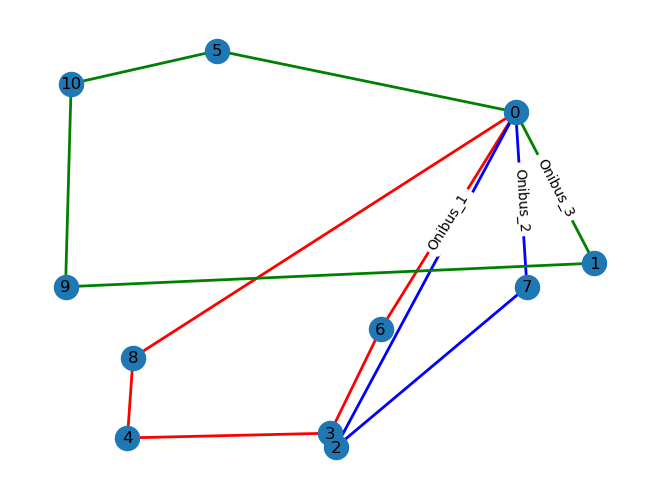

In [72]:
nx.draw(G2, pos, with_labels=True, edge_color = cores, width = pesos)
nx.draw_networkx_edge_labels(G2, pos, edge_labels = rotulos)
plt.savefig('Grafo2_lista_2_2opt')
plt.show()

In [73]:
calcula_custo(rotas2)

630.8699932098389